In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

In [7]:
pip install pandas_gbq

  Obtaining dependency information for pydata-google-auth>=1.5.0 from https://files.pythonhosted.org/packages/28/6b/3320c9ddbfc572108917e8432a07e8bd1e40054d94b5ad40c755afdc1160/pydata_google_auth-1.8.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for google-api-core<3.0.0dev,>=2.10.2 from https://files.pythonhosted.org/packages/6e/c4/c3cd048b6cbeba8d9ae50dd7643ac065b85237338aa7501b0efae91eb4d9/google_api_core-2.11.1-py3-none-any.whl.metadata
  Obtaining dependency information for google-auth-oauthlib>=0.7.0 from https://files.pythonhosted.org/packages/ce/33/a907b4b67245647746dde8d61e1643ef5d210c88e090d491efd89eff9f95/google_auth_oauthlib-1.1.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for google-cloud-bigquery!=2.4.*,<4.0.0dev,>=3.3.5 from https://files.pythonhosted.org/packages/cc/6a/d0ef792288f2fa2cfea80899a82de302b3332dfda41984fe114e2cfbf700/google_cloud_bigquery-3.11.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for go

In [8]:

import pandas as pd
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq
credentials_path = '../token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [9]:
from pandas_gbq import read_gbq
merged_data = read_gbq(f"""
SELECT *
FROM `capstone-398012.capstone.filled_table`

""",project_id='capstone-398012', dialect='standard')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/google/cloud/bigquery/table.py:2158: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


In [10]:
merged_data.head()

,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,m2b_notNA,ni2talevel_notNA,ni2tatrend_notNA,lqfintrend_notNA,liqfinlevel_notNA,sizelevel_notNA,sizetrend_notNA
0,26990,2023,7,0.110445,0.009928,4.874043,0.537756,0.0,0.0,0.003009,...,1,1,1,1,1,1,1,1,1,1
1,27030,2023,7,0.110445,0.009928,3.875769,0.519613,0.0,0.0,0.002722,...,1,1,1,1,1,1,1,1,1,1
2,27035,2023,7,0.110445,0.009928,2.130511,0.361442,0.0,0.0,0.000949,...,1,1,1,1,1,1,1,1,1,1
3,27037,2023,7,0.110445,0.009928,5.436649,-3.216218,0.0,0.0,-0.002387,...,1,1,1,1,1,1,1,1,1,1
4,27101,2023,7,0.110445,0.009928,2.708044,-1.008044,0.0,0.0,0.000757,...,1,1,1,1,1,1,1,1,1,1


In [11]:
#list of columns that contain NA 
na_cols = ['liqnonfinlevel', 'liqnonfintrend', 'dtdlevel', 'dtdtrend', 'DTDmedianNonFin', 'Sector_Number', 'DTDmedianFin', 'sigma', 'StkIndx']

new_df = merged_data.copy()
new_df['Event_type'] = new_df['Event_type'].map(lambda x : 0 if x ==2  else x)
#create new columns (_notNA) for each column that contains na values where 1 if original column is not na and 0 otherwise
for col in na_cols:
    new_col = col + '_notNA'
    new_df[new_col] = new_df[col].notna().astype(int)

grouped_df = new_df.groupby('CompNo')
grouped_df[na_cols].mean()
mean_values = grouped_df[na_cols].transform('mean')

new_df[na_cols] = new_df[na_cols].fillna(mean_values)
print(new_df['Event_type'].sum())
new_df.isna().sum().sort_values(ascending=False)
print(new_df['Event_type'].sum())



75
75


In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
numerical = ['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel', 'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend', 'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin']
categorical= [
    'Event_type', 
    'yyyy', 
    'mm', 
 'Sector_Number',
 'Exchange',
 'liqnonfinlevel_notNA',
 'liqnonfintrend_notNA',
 'dtdlevel_notNA',
 'dtdtrend_notNA',
 'DTDmedianNonFin_notNA',
 'Sector_Number_notNA',
 'DTDmedianFin_notNA',
 'sigma_notNA',
 'StkIndx_notNA']
y = new_df['Event_type']
X = new_df.drop(['CompNo'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numerical]), columns=numerical)
X_train_scaled.index = X_train.index
X_train_scaled = pd.concat([X_train_scaled, X_train[categorical]] ,axis=1)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numerical]), columns=numerical)
X_test_scaled.index = X_test.index
X_test_scaled = pd.concat([X_test_scaled, X_test[categorical]], axis=1)


In [54]:
# Creating the X, T and E inputs
#X_train_scaled['Event_date'] = X_train_scaled['transformed_year'] + X_train_scaled['mm'].astype(int)
#X_test_scaled['Event_date'] = X_test_scaled['transformed_year'] + X_test_scaled['mm'].astype(int)
X_train_scaled['transformed_year'] = X_train_scaled['yyyy'].apply(lambda x: x - 1999)
X_test_scaled['transformed_year'] = X_test_scaled['yyyy'].apply(lambda x: x - 1999)

#X_train, X_test = data_train[features], data_test[features]
T_train, T_test = X_train_scaled['transformed_year'], X_test_scaled['transformed_year']
E_train, E_test = X_train_scaled['Event_type'], X_test_scaled['Event_type']

In [55]:
from pysurvival.models.multi_task import NeuralMultiTaskModel

# Initializing the Neural MTLR with a time axis split into 100 intervals
structure = [
                {'activation': 'ReLU', 'num_units': 60},
                {'activation': 'Swish', 'num_units': 60},
            ]
neural_mtlr = NeuralMultiTaskModel(bins=100, structure=structure)

# Fitting the model
neural_mtlr.fit(X_train_scaled, T_train, E_train,
                init_method = 'orthogonal', optimizer ='rprop', lr = 1e-4,
                l2_reg = 1e-1,  l2_smooth = 1e-1,
                batch_normalization = True,  bn_and_dropout = True,
                dropout=0.5,  num_epochs = 500)

% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


NeuralMultiTaskModel( Layer(1): activation = ReLU, units = 60 ; 
                      Layer(2): activation = Swish, units = 60 )

In [56]:
# Assuming you have a test dataset X_test_scaled
# Make predictions on the test dataset
predictions = neural_mtlr.predict_risk(X_test_scaled)

# 'predictions' is a 2D array-like object with predicted risks


In [51]:
!pip3 install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for autograd>=1.5 from https://files.pythonhosted.org/packages/81/70/d5c7c2a458b8be96495c8b1634c2155beab58cbe864b7a9a5c06c2e52520/autograd-1.6.2-py3-none-any.whl.metadata
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for formulaic>=0.2.2 from https://files.pythonhosted.org/packages/db/97/2ac97273f77138c4248ab63cdc4799ea3c87ea2be2d28bb726562e0d0827/formulaic-0.6.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 3.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB

/Users/zhiqian/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == "__main__":


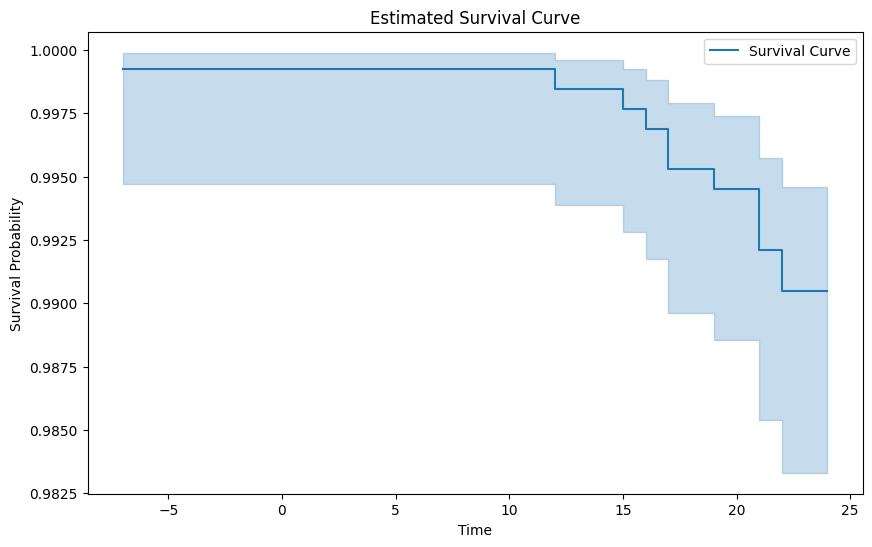

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Assuming you have predicted risk scores in 'predicted_risk' for your dataset
# and 'time_points' representing the time points of interest

# Convert predicted risk scores to hazard rates
hazard_rates = np.exp(predictions)

# Create a Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the estimator to your data (T represents event times, E represents event status)
kmf.fit(durations=T_test, event_observed=E_test, entry=None, label="Survival Curve")

# Plot the estimated survival curve
plt.figure(figsize=(10, 6))
kmf.plot()
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Estimated Survival Curve")
plt.show()


In [47]:
predictions

array([1.13971421e+04, 7.56503618e+04, 6.12410391e+04, ...,
       4.49328125e+03, 1.18589245e+01, 4.60229851e+04])

In [45]:
# Assuming you have a test dataset X_test_scaled, T_test, and E_test

# Make predictions on the test dataset
predictions = neural_mtlr.predict_risk(X_test_scaled)

# Calculate the C-index manually
total_pairs = 0
concordant_pairs = 0

# Check if the lengths of T_test and predictions match
if len(T_test) != len(predictions):
    raise ValueError("Lengths of T_test and predictions must match.")

for i in range(len(T_test)):
    for j in range(i + 1, len(T_test)):
        if (T_test[i] < T_test[j]) and (predictions[i] < predictions[j]):
            concordant_pairs += 1
        elif (T_test[i] > T_test[j]) and (predictions[i] > predictions[j]):
            concordant_pairs += 1
        total_pairs += 1

# Check if total_pairs is zero to avoid division by zero
if total_pairs == 0:
    raise ValueError("No pairs to compare. Check your data.")

# Calculate the C-index
c_index = concordant_pairs / total_pairs

# Print the C-index
print("Concordance Index (C-index): {:.4f}".format(c_index))


KeyError: 0

In [37]:
neural_mtlr.predict(X_test_scaled)

(array([[2.80796288e-18, 2.75583521e-18, 2.70048542e-18, ...,
         1.14553780e+00, 1.67393244e+00, 1.06882060e+00],
        [2.31657793e-18, 2.29761122e-18, 2.27509449e-18, ...,
         2.29902929e+00, 3.02901992e+00, 1.17188217e+00],
        [3.23847831e-18, 3.21844074e-18, 3.19731270e-18, ...,
         2.11637018e+00, 2.76489305e+00, 1.09432343e+00],
        ...,
        [2.96832700e-16, 2.94332303e-16, 2.92395304e-16, ...,
         8.87864059e-01, 6.24110411e-01, 5.28944916e-01],
        [4.69542105e-10, 4.76380145e-10, 4.82616001e-10, ...,
         1.72094488e-01, 3.80369448e-01, 7.40277319e-01],
        [2.17660496e-17, 2.16521731e-17, 2.15018756e-17, ...,
         2.19605888e+00, 2.47642491e+00, 1.03428238e+00]]),
 array([[2.80796288e-18, 2.75583521e-18, 2.70048542e-18, ...,
         6.85798348e-09, 2.11660829e-09, 1.98032138e-09],
        [2.31657793e-18, 2.29761122e-18, 2.27509449e-18, ...,
         7.50960958e-11, 1.33771290e-11, 1.14150803e-11],
        [3.23847831e-18, 

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report

# class_weights = {0:1, 1:100}
#model = LogisticRegression(class_weight = class_weights)
#model.fit(X_train_scaled, y_train)
# y_pred = neural_mtlr.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
coefficients = neural_mtlr.coef_
intercept = neural_mtlr.intercept_


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(classification_rep)

Mean Squared Error: 551686304.2113545
R-squared: -61931791604.13236


AttributeError: 'NeuralMultiTaskModel' object has no attribute 'coef_'

## Logistic Regression

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
class_weights = {0:1, 1:10}
model = LogisticRegression(class_weight = class_weights)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
coefficients = model.coef_
intercept = model.intercept_


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(classification_rep)

Mean Squared Error: 0.02247191011235955
R-squared: -1.5226757369614514
Confusion Matrix:
[[1297   26]
 [   4    8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1323
           1       0.24      0.67      0.35        12

    accuracy                           0.98      1335
   macro avg       0.62      0.82      0.67      1335
weighted avg       0.99      0.98      0.98      1335



/Users/thomastan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Linear Regression


In [161]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Mean Squared Error: 0.007632149265912448
R-squared: 0.14322201905764587
Coefficients: [-0.00375393 -0.06441143 -0.00042193  0.00141503 -0.00767383  0.0026687
  0.00420604  0.00046814 -0.01633283 -0.00045575  0.00038404 -0.00825186
  0.00168323 -0.00028511 -0.04249975  0.0243767   0.05637428 -0.00145505
 -0.11732824  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
Intercept: 1.8148447662827003
